In [55]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import nltk
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import gensim.downloader as api
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
#fork

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [56]:
#MULTI LABEL

In [57]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Function Creation and Setup

In [58]:

# nltk.download('all')
# for package in ['stopwords','punkt','wordnet']:
#     nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 

In [59]:
# class lemmaTokenizer(object):
#     def __init__(self, stop_words):
#         self.stop_words = stop_words
#         self.lemmatizer = WordNetLemmatizer()
#     def __call__(self, doc):
#         tokens = word_tokenize(doc)
#         filtered_tok = []
#         for tok in tokens:
#             if tok not in stop_words:
#                 tok = re.sub('\W+','', tok) #Punctuation strip
#                 tmp = self.lemmatizer.lemmatize(tok)
#                 if len(tmp) >= 2:
#                     filtered_tok.append(tmp)
#         return filtered_tok

In [60]:
#tok = lemmaTokenizer(stop_words)
#train_df["clean_text"] = train_df["comment_text"].apply(lambda x: tok(x))

In [61]:
toxic = train_df[["id","comment_text","toxic"]]

In [62]:
sToxic = train_df[["id","comment_text","severe_toxic"]]

In [63]:
obscene = train_df[["id","comment_text","obscene"]]

In [64]:
threat = train_df[["id","comment_text","threat"]]

In [65]:
idHate = train_df[["id","comment_text","identity_hate"]]

In [66]:
insult = train_df[["id","comment_text","insult"]]

#### Model Creation

In [67]:
#modelTwitter =  api.load("glove-twitter-25")

In [68]:
# w2vTwitter = dict(zip(modelTwitter.index_to_key, modelTwitter.vectors))

# #for converting sentence to vectors/numbers from word vectors result by Word2Vec
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

In [69]:
#twitterEmbedded = MeanEmbeddingVectorizer(w2vTwitter)
tfidfVectorizor = TfidfVectorizer(max_features=5000,stop_words='english')
cleanText = tfidfVectorizor.fit_transform(train_df['comment_text'])

# Problems
- Clean the text of punctuation

# Toxic

AUC: 0.9650105801394994
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     36161
           1       0.90      0.61      0.73      3732

    accuracy                           0.96     39893
   macro avg       0.93      0.80      0.85     39893
weighted avg       0.96      0.96      0.95     39893



<AxesSubplot:>

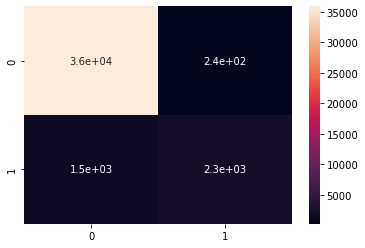

In [70]:
 # Split data - using the new dataframe parts that we cleaned up. 
toxic = train_df[["id","comment_text","toxic"]]
X_train, X_test, y_train, y_test = train_test_split(cleanText,toxic["toxic"])

#model fitting
toxicModel = LogisticRegression(n_jobs=-1)
toxicModel.fit(X_train, y_train)

#Predict y value for test dataset
y_predict = toxicModel.predict(X_test)
y_prob = toxicModel.predict_proba(X_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Severely Toxic

AUC: 0.9843512824409929
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39477
           1       0.56      0.26      0.36       416

    accuracy                           0.99     39893
   macro avg       0.78      0.63      0.68     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

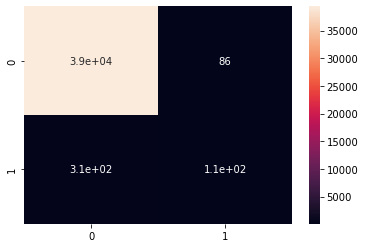

In [71]:
 # Split data - using the new dataframe parts that we cleaned up. 
severeToxic = train_df[["id","comment_text","severe_toxic"]]
stX_train, stX_test, sty_train, sty_test = train_test_split(cleanText,severeToxic["severe_toxic"])

#model fitting
severeToxicModel = LogisticRegression(n_jobs=-1)
severeToxicModel.fit(stX_train, sty_train)

#Predict y value for test dataset
sty_predict = severeToxicModel.predict(stX_test)
sty_prob = severeToxicModel.predict_proba(stX_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(sty_test, sty_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(sty_test, sty_predict))
sns.heatmap(confusion_matrix(sty_test, sty_predict), annot=True)

# Obscene

AUC: 0.9788989745744338
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     37790
           1       0.92      0.65      0.76      2103

    accuracy                           0.98     39893
   macro avg       0.95      0.82      0.87     39893
weighted avg       0.98      0.98      0.98     39893



<AxesSubplot:>

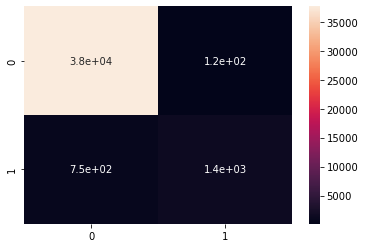

In [72]:
 # Split data - using the new dataframe parts that we cleaned up. 
obscene = train_df[["id","comment_text","obscene"]]
oX_train, oX_test, oy_train, oy_test = train_test_split(cleanText,obscene["obscene"])

#model fitting
obsceneModel = LogisticRegression(n_jobs=-1)
obsceneModel.fit(oX_train, oy_train)

#Predict y value for test dataset
oy_predict = obsceneModel.predict(oX_test)
oy_prob = obsceneModel.predict_proba(oX_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(oy_test, oy_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(oy_test, oy_predict))
sns.heatmap(confusion_matrix(oy_test, oy_predict), annot=True)

# Insult

AUC: 0.9695292443822433
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     37886
           1       0.82      0.52      0.63      2007

    accuracy                           0.97     39893
   macro avg       0.90      0.76      0.81     39893
weighted avg       0.97      0.97      0.97     39893



<AxesSubplot:>

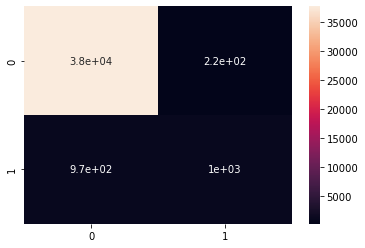

In [73]:
 # Split data - using the new dataframe parts that we cleaned up. 
insult = train_df[["id","comment_text","insult"]]
iX_train, iX_test, iy_train, iy_test = train_test_split(cleanText,insult["insult"])

#model fitting
insultModel = LogisticRegression(n_jobs=-1)
insultModel.fit(iX_train, iy_train)

#Predict y value for test dataset
iy_predict = insultModel.predict(iX_test)
iy_prob = insultModel.predict_proba(iX_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(iy_test, iy_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(iy_test, iy_predict))
sns.heatmap(confusion_matrix(iy_test, iy_predict), annot=True)

# Identity Hate

AUC: 0.9663541497178992
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39548
           1       0.63      0.19      0.29       345

    accuracy                           0.99     39893
   macro avg       0.81      0.59      0.64     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

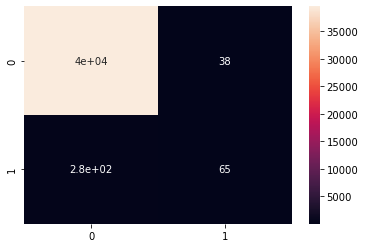

In [74]:
 # Split data - using the new dataframe parts that we cleaned up. 
identityHate = train_df[["id","comment_text","identity_hate"]]
idhX_train, idhX_test, idhy_train, idhy_test = train_test_split(cleanText,identityHate["identity_hate"])

#model fitting
identityHateModel = LogisticRegression(n_jobs=-1)
identityHateModel.fit(idhX_train, idhy_train)

#Predict y value for test dataset
idhy_predict = identityHateModel.predict(idhX_test)
idhy_prob = identityHateModel.predict_proba(idhX_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(idhy_test, idhy_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(idhy_test, idhy_predict))
sns.heatmap(confusion_matrix(idhy_test, idhy_predict), annot=True)

# Threat

AUC: 0.9830699194159452
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39781
           1       0.57      0.19      0.28       112

    accuracy                           1.00     39893
   macro avg       0.78      0.59      0.64     39893
weighted avg       1.00      1.00      1.00     39893



<AxesSubplot:>

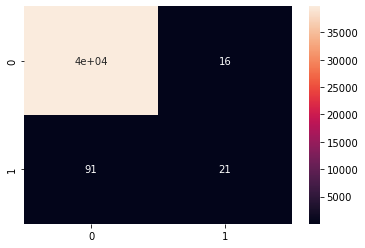

In [75]:
 # Split data - using the new dataframe parts that we cleaned up. 
threat = train_df[["id","comment_text","threat"]]
tX_train, tX_test, ty_train, ty_test = train_test_split(cleanText,threat["threat"])

#model fitting
threatModel = LogisticRegression(n_jobs=-1)
threatModel.fit(tX_train, ty_train)

#Predict y value for test dataset
ty_predict = threatModel.predict(tX_test)
ty_prob = threatModel.predict_proba(tX_test)[:,1]
 
#calculate scores
fpr, tpr, thresholds = roc_curve(ty_test, ty_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(ty_test, ty_predict))
sns.heatmap(confusion_matrix(ty_test,ty_predict), annot=True)

## Test Data

In [76]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [80]:
testCleanText = tfidfVectorizor.fit_transform(test_df['comment_text'])

In [81]:
# Toxic final prediction
yToxic = toxicModel.predict(testCleanText)

#Severely toxic final prediction
ySevere = severeToxicModel.predict(testCleanText)

#Obscene final prediction
yObscene = obsceneModel.predict(testCleanText)

#Insult final prediction
yInsult = insultModel.predict(testCleanText)

#Identity Hate final prediction
yIDHate = identityHateModel.predict(testCleanText)

#Threat final prediction
yThreat = threatModel.predict(testCleanText)

In [ ]:
#now kith
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
thisIsGoingOut = pd.DataFrame(list(zip(test_df["id"], yToxic, ySevere,yObscene, yThreat, yInsult, yIDHate)),
                              columns=columns)
thisIsGoingOut.to_csv('out.csv', index=False)  

## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
# dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
# dummy_toxic = [0,0,0,0]
# dummy_severe = [0,0,0,0]
# dummy_obscene = [0,1,1,0]
# dummy_threat = [0,1,0,1]
# dummy_insult = [0,0,1,0]
# dummy_ident = [0,1,1,0]
# columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
#                     columns=columns)
# sample_out.head()

In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
# sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>